# Análise dos dados de  scRNA-seq:  

## Inflammatory Regulon Analysis — Overview and Workflow


### Dataset
This notebook uses **single-cell RNA-seq data from neutrophils**, previously annotated into **maturation stages**:
- **G1–G4**: bone marrow neutrophils  
- **G5a, G5b, G5c**: circulating (blood) neutrophils  

The dataset already contains cell-type annotations and differential expression results.

### Input
- An **scRNA-seq AnnData (`.h5ad`) object** containing:
  - Cell annotations (neutrophil maturation stages)
  - Normalized expression layers
  - Differentially expressed genes (DEGs)
- **SCENIC output files** (`adj.csv`) for each experimental group, describing transcription factor (TF) → target gene regulatory interactions
- Curated **pro-inflammatory** and **anti-inflammatory gene sets** (derived from GO terms)

### Output
- Heatmaps showing **pro-inflammatory and anti-inflammatory regulatory programs** across neutrophil maturation stages
- These patterns are interpreted **in the context of transcription factor regulons inferred by SCENIC**, highlighting how inflammatory regulation changes along neutrophil differentiation and between conditions

---

### Workflow Description

1. **Data loading and preprocessing**
   - Load the annotated neutrophil AnnData object.
   - Remove unwanted cell populations (e.g. G0 cells).
   - Define ordered maturation stages (G1–G5c) and consistent color schemes.
   - Split the AnnData object by experimental group (bone marrow vs blood, WT vs KO).

2. **Cell composition sanity check**
   - Count the number of cells per neutrophil stage in each group.
   - Store these counts for quality control and interpretation.

3. **Definition of inflammatory gene sets**
   - Import curated gene lists associated with:
     - **Pro-inflammatory responses**
     - **Anti-inflammatory responses**
   - These gene sets serve as biological priors to classify regulatory interactions.

4. **Filtering SCENIC regulons by inflammatory context**
   - Load SCENIC adjacency tables (TF–target interactions).
   - For each TF, retain the top interactions ranked by importance.
   - Classify regulons as:
     - **Exclusively pro-inflammatory**
     - **Exclusively anti-inflammatory**
   - This step links transcription factors to coherent inflammatory programs.

5. **Integration with expression data**
   - Import mean expression Z-score matrices for each group.
   - Intersect SCENIC-derived target genes with expression data.
   - Apply Z-score thresholds to focus on biologically relevant regulation patterns.

6. **Visualization**
   - Generate paired heatmaps for each group:
     - Anti-inflammatory regulon targets
     - Pro-inflammatory regulon targets
   - Heatmaps are organized by neutrophil maturation stage, enabling direct comparison of regulatory programs across differentiation and conditions.

---

### Biological Interpretation
This notebook connects **transcription factor activity (SCENIC regulons)** with **inflammatory gene programs**, allowing the identification of:
- Stage-specific inflammatory regulation during neutrophil maturation
- Differences between bone marrow and blood neutrophils
- Condition-dependent shifts in pro- vs anti-inflammatory regulatory states

The result is a regulatory, not just transcriptional, view of neutrophil inflammation across maturation.


In [ ]:
from numba.core.errors import NumbaDeprecationWarning
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sc.set_figure_params(figsize=(5, 5))

## Load data

In [ ]:
#### Load the data and remove G0 cells
# Read the AnnData object containing DEG/MAST results
adata = sc.read("/home/tahila/2506_scRNA_Neutrofilos_2/04.DEGs_MAST_output.h5ad")

# Exclude cells annotated as G0 (baseline / non-maturing population)
adata = adata[adata.obs['manual_celltype_annotation'] != 'G0'].copy()

#### Define subtype categories and corresponding colors
# Explicit ordering of neutrophil maturation states
celltype_order = ["G1", "G2", "G3", "G4", "G5a", "G5b", "G5c"]

# Color palette used consistently across plots
colors_dict = {
    "G1": "#68009cff",
    "G2": "#ffea00ff",
    "G3": "#3c78d8ff",
    "G4": "#ff9900ff",
    "G5a": "#d786c4ff",
    "G5b": "#000000",
    "G5c": "#0097a7ff"
}

# Convert the annotation column to an ordered categorical variable
adata.obs['manual_celltype_annotation'] = pd.Categorical(
    adata.obs['manual_celltype_annotation'],
    categories=celltype_order,
    ordered=True
)

# Register colors in adata.uns so Scanpy uses them automatically
adata.uns["manual_celltype_annotation_colors"] = [
    colors_dict[g] for g in celltype_order
]

#### Split AnnData objects by experimental group (CREATE adatas DICTIONARY)
adatas = {}

# Bone marrow samples: keep all maturation states
for group in ['BM_WT', 'BM_KO']:
    adatas[group] = {
        'adata': adata[adata.obs['Sample_grouped'] == group].copy()
    }

# Peripheral blood samples: keep only late G5 subtypes
for group in ['BL_WT', 'BL_KO']:
    mask = (
        (adata.obs['Sample_grouped'] == group) &
        (adata.obs['manual_celltype_annotation']
             .astype(str)
             .str.startswith('G5'))
    )
    adatas[group] = {
        'adata': adata[mask].copy()
    }

#### Define global parameters used downstream
# Column used to define cell identities / regulon comparison
groupby_col = 'manual_celltype_annotation'

# Expression layer used for downstream analyses (SoupX-corrected counts)
layer = 'log_soupX_counts'

# List of experimental groups present in the dataset
groups = adata.obs['Sample_grouped'].unique().tolist()
# Expected: ['BL_WT', 'BL_KO', 'BM_WT', 'BM_KO']


In [ ]:
# List of experimental groups to be analyzed
group_list = ['BL_WT', 'BL_KO', 'BM_WT', 'BM_KO']

# Dictionary to store cell counts per subtype for each group
counts_dict = {}

# Iterate over each group and count cells by maturation subtype
for group in group_list:
    # Retrieve the AnnData object for the current group
    adata_group = adatas[group]['adata']
    
    # Count the number of cells per neutrophil subtype
    counts = adata_group.obs['manual_celltype_annotation'].value_counts()
    
    # Store the counts in the dictionary
    counts_dict[group] = counts

# Convert the dictionary into a DataFrame
# Missing combinations are filled with zero and cast to integers
df_counts = pd.DataFrame(counts_dict).fillna(0).astype(int)

# Reorder rows to follow the predefined biological maturation order
group_order = ["G1", "G2", "G3", "G4", "G5a", "G5b", "G5c"]
df_counts = df_counts.reindex(group_order)

# Display the final table of cell counts per group and subtype
df_counts


,BL_WT,BL_KO,BM_WT,BM_KO
manual_celltype_annotation,,,,
G1,0,0,198,310
G2,0,0,736,806
G3,0,0,1634,2027
G4,0,0,2725,2842
G5a,6205,3100,2620,3469
G5b,184,135,83,100
G5c,791,772,280,522


In [ ]:
# Column name in the GO tables that contains the gene identifiers
gene_col_name = 'MGI Gene/Marker ID'

# Load genes associated with a positive regulation of inflammatory response
proinfl = pd.read_csv(
    '/home/tahila/2507_scRNA_neutrofilos_poster/04.genes_expressos_inflamacao/GO_term_positive_repsonse_20250718_145926.txt',
    sep='\t'
)

# Extract unique, non-null gene IDs and store them as a set
# (sets are useful for fast membership tests and intersections)
proinfl = set(proinfl[gene_col_name].dropna().unique().tolist())

# Load genes associated with a negative regulation of inflammatory response
antinfl = pd.read_csv(
    '/home/tahila/2507_scRNA_neutrofilos_poster/04.genes_expressos_inflamacao/GO_term_negative_response_20250718_145843.txt',
    sep='\t'
)

# Extract unique, non-null gene IDs and store them as a set
antinfl = set(antinfl[gene_col_name].dropna().unique().tolist())


In [ ]:
def filter_scenic_by_inflammation(scenic_complete, proinfl, antinfl, n_top_interactions=100):
    """
    Adds inflammation-related boolean annotations to a SCENIC interaction DataFrame
    and returns two filtered subsets:
    - df_anti: regulons exclusively associated with anti-inflammatory genes
    - df_pro: regulons exclusively associated with pro-inflammatory genes

    Parameters:
    ----------
    scenic_complete : pd.DataFrame
        SCENIC results table containing at least the columns ['TF', 'target', 'importance'].
    proinfl : set
        Set of genes annotated as pro-inflammatory.
    antinfl : set
        Set of genes annotated as anti-inflammatory.
    n_top_interactions : int
        Number of top-ranked target genes (by importance) to keep per TF.

    Returns:
    -------
    df_anti : pd.DataFrame
        Subset of SCENIC interactions where both TF and target are anti-inflammatory
        and neither is pro-inflammatory.
    df_pro : pd.DataFrame
        Subset of SCENIC interactions where both TF and target are pro-inflammatory
        and neither is anti-inflammatory.
    """

    # Helper function to test whether a gene belongs to a given inflammation-related set
    def is_inflam(gene, infl_set):
        return gene in infl_set
    
    # Sort interactions by TF and importance, keeping the strongest targets per TF
    df_filtered = scenic_complete.sort_values(
        ['TF', 'importance'], ascending=[True, False]
    )

    # Keep only the top N interactions per TF
    scenic_df = df_filtered.groupby('TF').head(n_top_interactions)

    # Explicitly remove Ffar2 as a target (manual exclusion)
    scenic_df = scenic_df[scenic_df['target'] != 'Ffar2']

    # Add boolean annotations indicating inflammatory status of TFs and targets
    scenic_df = scenic_df.copy()
    scenic_df['TF_antinfl'] = scenic_df['TF'].apply(lambda g: is_inflam(g, antinfl))
    scenic_df['target_antinfl'] = scenic_df['target'].apply(lambda g: is_inflam(g, antinfl))
    scenic_df['TF_proinfl'] = scenic_df['TF'].apply(lambda g: is_inflam(g, proinfl))
    scenic_df['target_proinfl'] = scenic_df['target'].apply(lambda g: is_inflam(g, proinfl))

    # Select exclusively anti-inflammatory interactions
    # (both TF and target are anti-inflammatory, and neither is pro-inflammatory)
    df_anti = scenic_df[
        (scenic_df['TF_antinfl']) &
        (scenic_df['target_antinfl']) &
        (~scenic_df['TF_proinfl']) &
        (~scenic_df['target_proinfl'])
    ].copy()

    # Select exclusively pro-inflammatory interactions
    # (both TF and target are pro-inflammatory, and neither is anti-inflammatory)
    df_pro = scenic_df[
        (scenic_df['TF_proinfl']) &
        (scenic_df['target_proinfl']) &
        (~scenic_df['TF_antinfl']) &
        (~scenic_df['target_antinfl'])
    ].copy()

    # Inform the user if no interactions were found in either category
    if df_anti.empty:
        print('No anti-inflammatory interactions')
    if df_pro.empty:
        print('No pro-inflammatory interactions')

    return df_anti, df_pro


In [ ]:
# ============================
# IMPORT DATA FROM ALL SAMPLES
# ============================

input_dir = '/home/tahila/2507_scRNA_neutrofilos_poster/04.Rank_genes_output'

# Iterate over each experimental group (e.g. BL_WT, BL_KO, BM_WT, BM_KO)
for group in groups:
    print(group)

    # Load SCENIC adjacency table (TF–target interactions with importance scores)
    scenic_df = pd.read_csv(
        f'/home/tahila/2506_scRNA_Neutrofilos_2/06.SCENIC_{group}/adj.csv',
        header=0
    )

    # Filter SCENIC interactions into exclusively anti-inflammatory and pro-inflammatory regulons
    anti, pro = filter_scenic_by_inflammation(scenic_df, proinfl, antinfl)

    # Load mean expression (z-score) per cell subtype for this group
    mean_expr_zscore = pd.read_csv(
        f"{input_dir}/{group}_mean_expr_zscore.csv",
        index_col=0
    ).dropna(how='all')

    # Store all relevant objects in the corresponding group entry
    adatas[group].update({
        'mean_expr_zscore': mean_expr_zscore,  # average expression profiles (z-scored)
        'scenic': scenic_df,                   # full SCENIC network
        'scenic_pro': pro,                     # pro-inflammatory regulons
        'scenic_anti': anti                    # anti-inflammatory regulons
    })


BL_WT
BL_KO
BM_WT
BM_KO


In [35]:
print(adatas['BL_KO']['scenic']['importance'].max)


<bound method Series.max of 0         1.884369e+01
1         1.716772e+01
2         1.596641e+01
3         1.423748e+01
4         1.228905e+01
              ...     
293179    7.596623e-18
293180    1.124992e-18
293181    3.780236e-19
293182    1.085563e-19
293183    8.641158e-20
Name: importance, Length: 293184, dtype: float64>


In [36]:
adatas['BL_KO']['scenic']

,TF,target,importance
0,Ltf,Itgb2l,1.884369e+01
1,Ltf,Camp,1.716772e+01
2,Ltf,Serpinb1a,1.596641e+01
3,Ltf,Mmp8,1.423748e+01
4,Nr3c2,Rgcc,1.228905e+01
...,...,...,...
293179,Bhlhe40,9930021J03Rik,7.596623e-18
293180,Nmi,Ecm1,1.124992e-18
293181,Ets2,Alox15,3.780236e-19
293182,Batf,Prg4,1.085563e-19


In [38]:
for group in groups:

    tab = adatas[group]['scenic'][:100]

## HEATMAP INFLAMMATION

In [ ]:
def PlotHeatmap_Markers(mean_expr_zscore, genes_list, title, ax, zscore_threshold=1.5, row_order=None, y_rotation=45):
    # Ensure index is treated as string to allow substring-based filtering
    genes_no_index = mean_expr_zscore.index.astype(str)

    # Select genes whose names contain any of the substrings in genes_list
    genes_filtrados = [g for g in genes_no_index if any(substr in g for substr in genes_list)]

    # If no genes match the provided list, exit with a warning
    if not genes_filtrados:
        print(f"Nenhum gene contendo os termos foi encontrado para {title}")
        return

    # Subset the z-score matrix to the selected genes
    zscore_filtered = mean_expr_zscore.loc[genes_filtrados]

    # Apply a Z-score threshold filter (keeps genes with strong expression in at least one condition)
    zscore_filtered = zscore_filtered[zscore_filtered.abs().max(axis=1) > zscore_threshold]

    # If no genes pass the Z-score threshold, exit with a warning
    if zscore_filtered.empty:
        print(f"Nenhum gene passou o filtro de Z-score > {zscore_threshold} em {title}")
        return

    # Transpose so that cell types (or stages) are rows and genes are columns
    zscore_plot = zscore_filtered.T

    # Reorder rows if a specific row order is provided
    if row_order is not None:
        # Keep only rows that actually exist in the data
        row_order = [r for r in row_order if r in zscore_plot.index]
        zscore_plot = zscore_plot.loc[row_order]

    # Generate the heatmap
    sns.heatmap(
        zscore_plot,
        cmap='RdBu_r',
        center=0,
        linewidths=0.3,
        linecolor='gray',
        cbar_kws={'label': 'Z-score Expression'},
        ax=ax
    )

    # Aesthetic adjustments
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Neutrophil Stage", fontsize=12)
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=y_rotation)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Return the filtered z-score matrix (genes x conditions) used for plotting
    return zscore_filtered


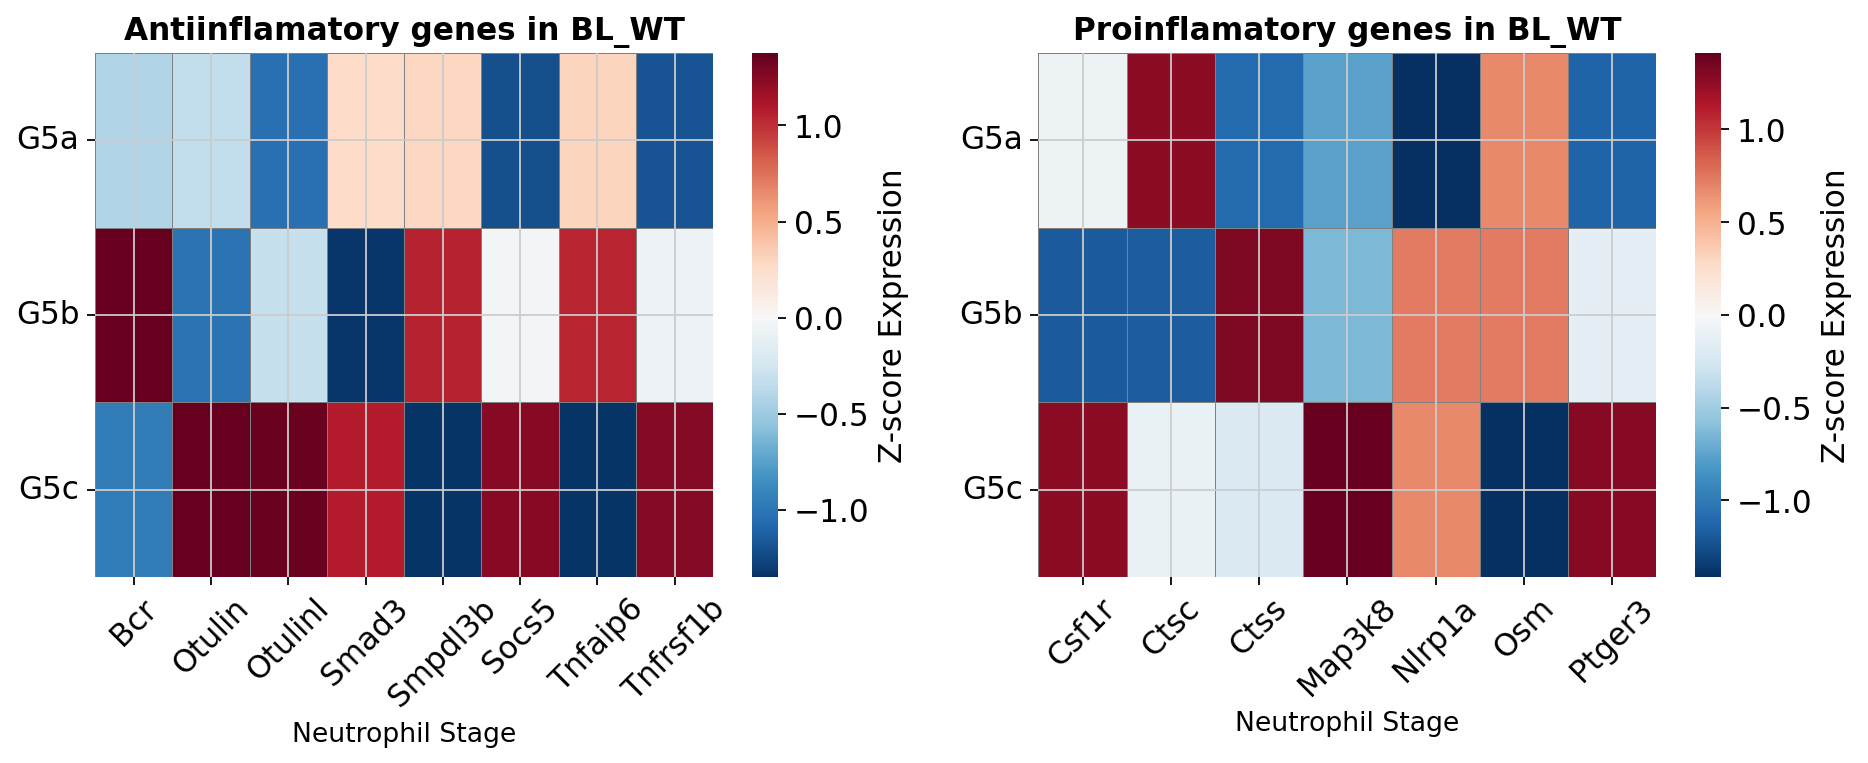

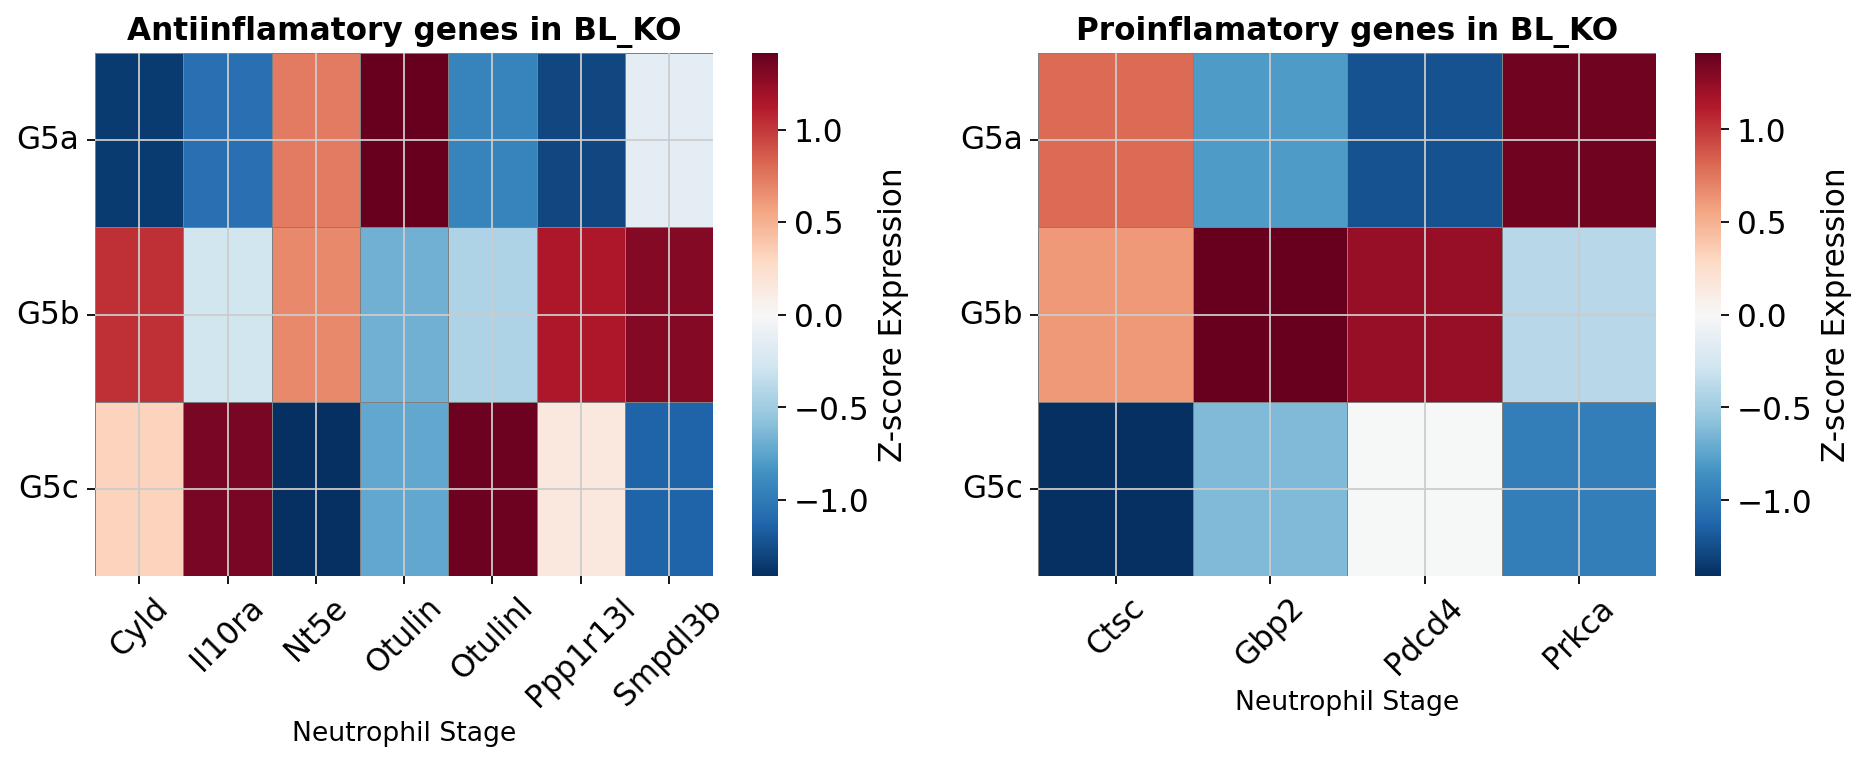

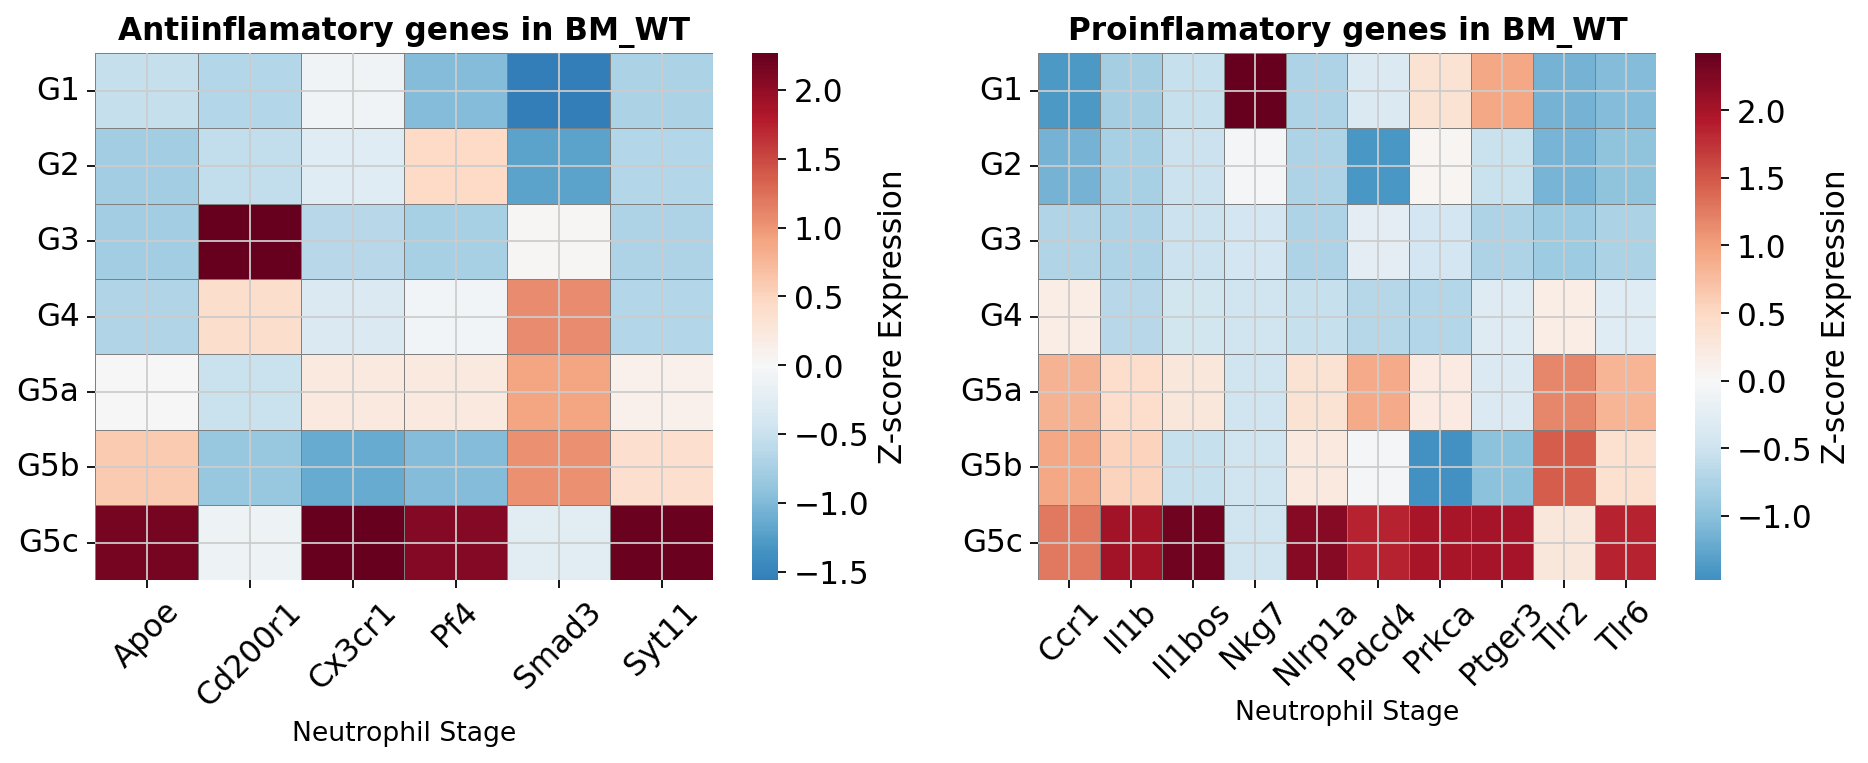

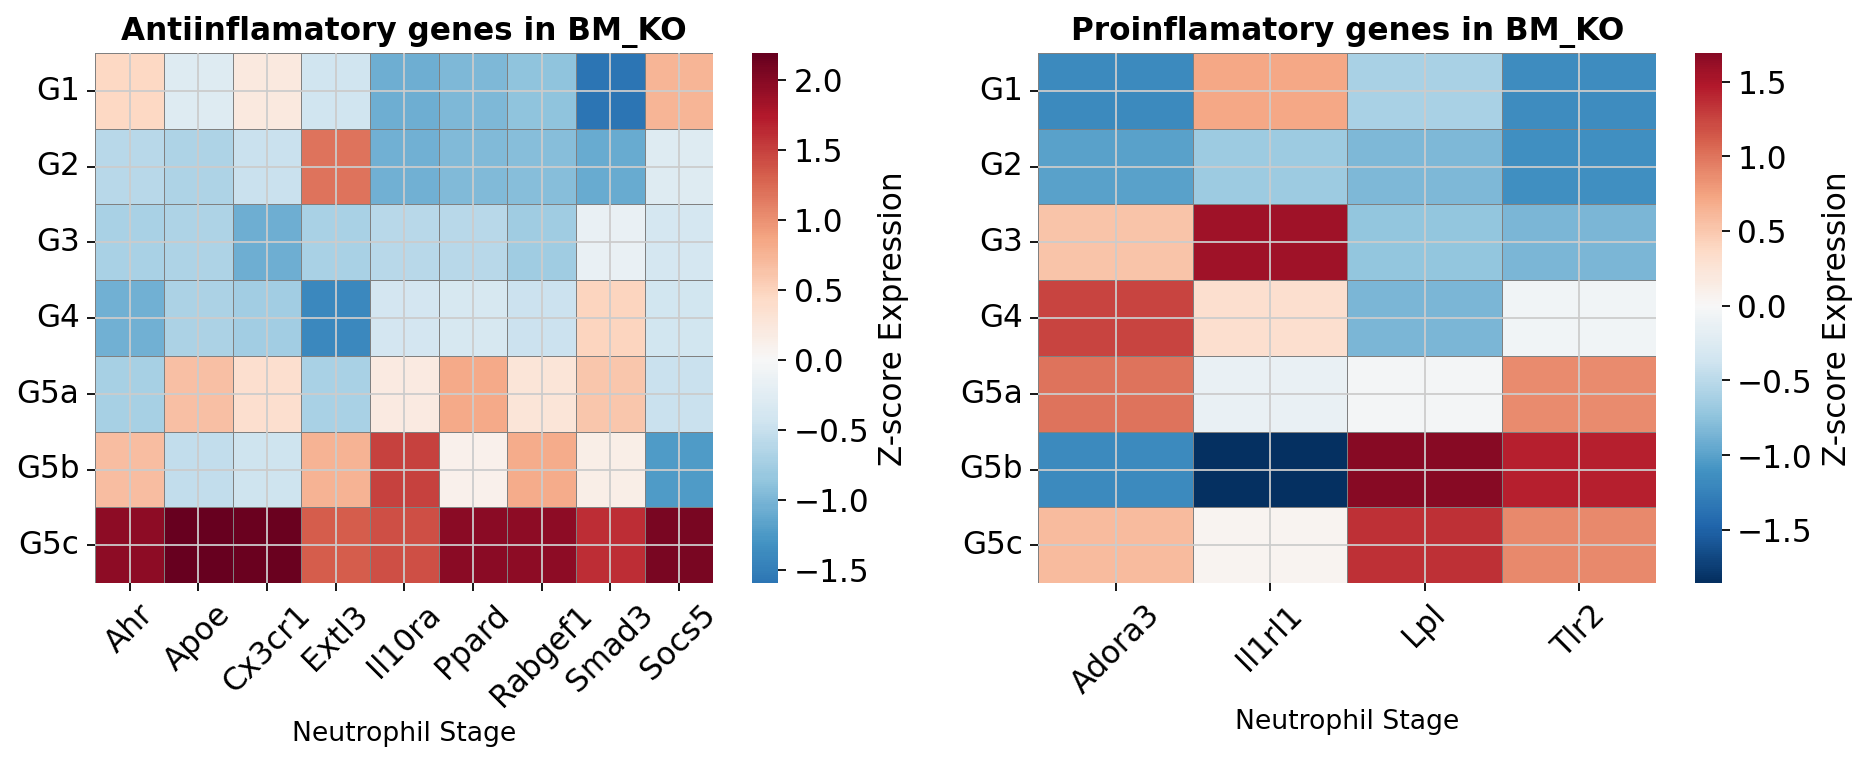

In [ ]:
# Initialize a dictionary to store Z-score matrices for each group
dic_zscores = {group: {} for group in groups}

# Loop over each experimental group
for group in groups:
    # Retrieve the mean expression Z-score matrix for the current group
    mean_expr_zscore = adatas[group]['mean_expr_zscore']
    
    # Get the list of anti-inflammatory target genes from SCENIC results
    antinfl = adatas[group]['scenic_anti']['target'].tolist()
    
    # Get the list of pro-inflammatory target genes from SCENIC results
    proinfl = adatas[group]['scenic_pro']['target'].tolist()

    # Create a figure with two side-by-side panels
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot heatmap for anti-inflammatory genes
    zscore_anti = PlotHeatmap_Markers(
        mean_expr_zscore,
        antinfl,
        f'Antiinflamatory genes in {group}',
        ax=axes[0],
        zscore_threshold=1.0
    )

    # Plot heatmap for pro-inflammatory genes
    zscore_pro = PlotHeatmap_Markers(
        mean_expr_zscore,
        proinfl,
        f'Proinflamatory genes in {group}',
        ax=axes[1],
        zscore_threshold=1.0
    )

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

    # Store the resulting filtered Z-score matrices for downstream analysis
    dic_zscores[group]['anti'] = zscore_anti
    dic_zscores[group]['pro'] = zscore_pro


## HEATMAP INFLAMAÇÃO - Juntos

In [12]:
for group in ['BL', 'BM']:
    
    mean_expr_zscore = pd.read_csv(f"{input_dir}/{group}_mean_expr_zscore.csv", index_col=0).dropna(how='all')
  
    if group not in adatas:
        adatas[group] = {}  # Cria um dicionário vazio para o grupo se ele não existir

    adatas[group]['mean_expr_zscore'] = mean_expr_zscore

adatas['BL']['mean_expr_zscore'].head(5)

,G5a_KO,G5b_KO,G5c_KO,G5a_WT,G5b_WT,G5c_WT
0610009L18Rik,0.659387,-1.413163,0.753777,-0.099115,-1.172176,1.271291
0610040F04Rik,-0.231306,-1.092599,1.323905,NaN,NaN,NaN
0610040J01Rik,0.010320,-1.229872,1.219552,-0.484490,-0.908386,1.392876
0610043K17Rik,-0.961191,1.378974,-0.417782,-1.382445,0.949359,0.433085
1110002L01Rik,-1.239685,1.209237,0.030448,-0.196952,-1.114334,1.311286


In [ ]:
dic_genes = {'BM': {'anti': [], 'pro': []},'BL': {'anti': [], 'pro': []}}

for tissue in ['BM','BL']:
    for infl in ['anti', 'pro']:
        ko = dic_zscores[f'{tissue}_KO'][infl].index.to_list()
        wt = dic_zscores[f'{tissue}_WT'][infl].index.to_list()
        dic_genes[tissue][infl] = set(ko + wt)

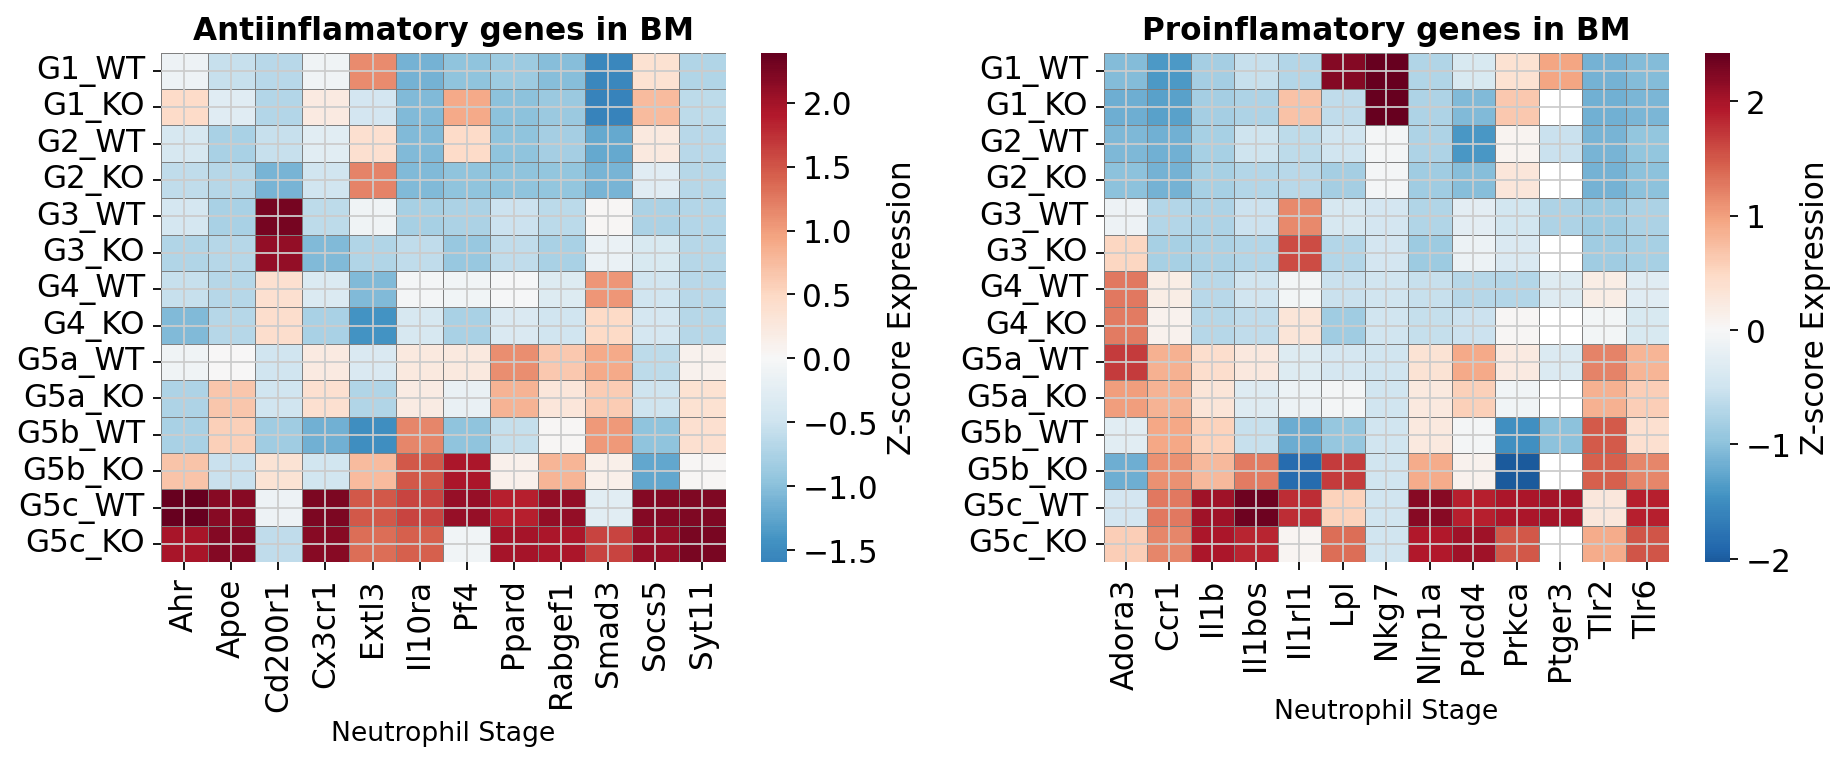

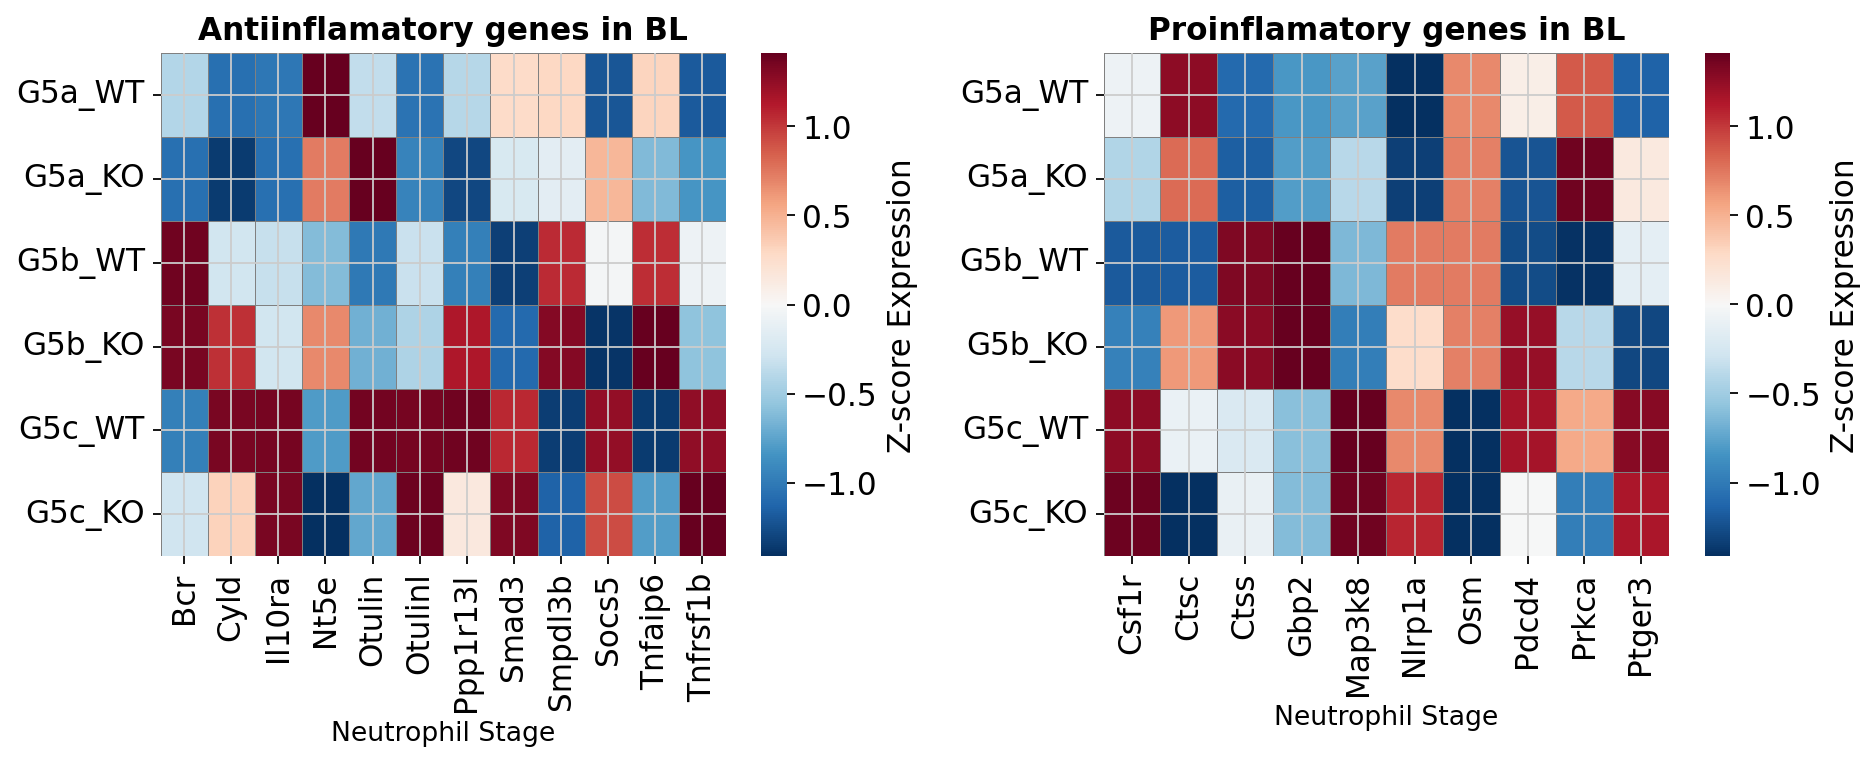

In [30]:
row_order = ['G1_WT', 'G1_KO', 'G2_WT','G2_KO', 'G3_WT', 'G3_KO', 'G4_WT', 'G4_KO', 'G5a_WT', 'G5a_KO', 'G5b_WT', 'G5b_KO', 'G5c_WT', 'G5c_KO']


for tissue in ['BM', 'BL']:
    mean_expr_zscore = adatas[tissue]['mean_expr_zscore']
    antinfl = dic_genes[tissue]['anti']
    proinfl = dic_genes[tissue]['pro']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    zscore_anti = PlotHeatmap_Markers(mean_expr_zscore, antinfl, f'Antiinflamatory genes in {tissue}', ax=axes[0], zscore_threshold=1.0, row_order=row_order, y_rotation=90)
    zscore_pro = PlotHeatmap_Markers(mean_expr_zscore, proinfl, f'Proinflamatory genes in {tissue}', ax=axes[1], zscore_threshold=1.0, row_order=row_order, y_rotation=90)

    plt.tight_layout()
    plt.show()